In [78]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pandas as pd
import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [10]:
def GS2dict():
    # Google API stuff
    scope = ["https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name('config/gcp-credentials.json', scope)
    client = gspread.authorize(creds)
    runs = ['run2', 'run3', 'run4', 'run5', 'run6']
    D = defaultdict(lambda: [])
    for run in runs:
        sheet = client.open('results_layers').worksheet(run)
        df = pd.DataFrame(sheet.get_all_records())
        D['SST2'].append(list(df['SST2'])) 
        D['QQP'].append(list(df['QQP']))
        D['MNLI'].append(list(df['MNLI']))
    for key in D.keys():
        D[key] = np.array(D[key]).transpose() #transpose
    return D

In [11]:
D = GS2dict()

In [12]:
stds, means = {}, {}
for key in D.keys():
    stds[key] = np.std(D[key], axis=1)
    #stds[key] = 0.02 + np.random.rand(13) * 0.02
    means[key] = np.mean(D[key], axis=1)

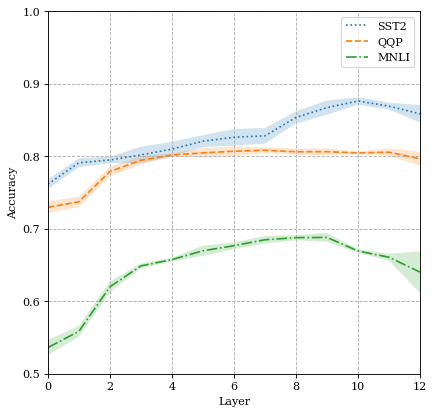

In [14]:
x = list(range(0, 13))
style = {'SST2': ':', 'MNLI': '-.', 'QQP': '--'}
fig = plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams["font.family"] = "serif"
for key in D.keys():
    plt.plot(x, means[key], style[key], label=key)
    plt.fill_between(x, means[key] + stds[key], means[key] - stds[key], alpha=0.2)
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Layer')
plt.grid(linestyle='--')
fig.axes[0].set_xlim([0, 12])
fig.axes[0].set_ylim([0.5, 1.0])
plt.savefig('figures/test.png')

In [116]:
from ast import literal_eval
from collections import defaultdict
import os
import glob

def text2dict(text):
    C = "Full test set compressions: "
    L = "Full test set losses: "
    start_C = text.find(C) + len(C)
    end_C = start_C + text[start_C:].find('}') + 1
    start_L = text.find(L) + len(L)
    end_L = start_L + text[start_L:].find('}') + 1
    compression_dict = literal_eval(text[start_C:end_C])
    eval_dict = literal_eval(text[start_L:end_L])
    results = {}
    for key in compression_dict.keys():
        results[key] = (compression_dict[key], eval_dict[key])
    return results

def listdir_nohidden(path):
    return glob.glob(os.path.join(path, '*'))

def plot_points(list_of_tuples, label=None):
    x = [t[0] for t in list_of_tuples]
    y = [t[1] for t in list_of_tuples]
    y = [v for _,v in sorted(zip(x,y))] # order w.r.t compression
    x.sort()
    plt.plot(x, y, label=label)

def read_file_in_dir(directory):
    files = listdir_nohidden(directory)
    all_results = defaultdict(lambda: {'SST2':[], 'MNLI':[], 'QQP':[]})
    for path in files:
        with open(path, 'r') as f:
            txt = f.read()
        R = text2dict(txt)
        name = os.path.basename(path).strip('.txt')
        for t in ['fixed', 'hard', 'agg', 'freq']:
            if t in name:
                kind = t
        for task in ['SST2', 'MNLI', 'QQP']:
            all_results[kind][task].append(R[task])
    return all_results

In [117]:
directory = "/Users/sergicastellasape/Desktop/layer10-mean/"
all_results = read_file_in_dir(directory)

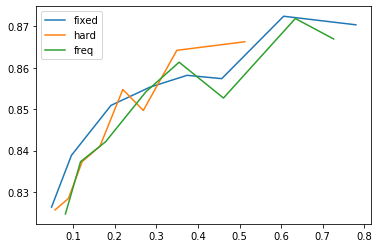

In [126]:
for kind in ['fixed', 'hard', 'freq']:
    plot_points(all_results[kind]['SST2'], label=kind)
    plt.legend()

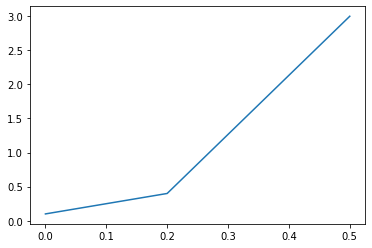

In [89]:
plot_points([(0, 0.1), (0.2, 0.4), (0.5, 3)])

In [6]:
len("{'SST2': 0.5627296244554766, 'MNLI': 0.6049953091621398, 'QQP': 0.6312304337778789}")

83